In [7]:
import pandas as pd
import numpy as np
 
# STEP 1: Load your dataset
df = pd.read_csv(r'floor2_with_weather (2).csv')  # Update this with your actual file
df['Timestamp'] = pd.to_datetime(df['Timestamp'])  # If not already in datetime
df.set_index('Timestamp', inplace=True)
df = df.sort_index()
 
# Optional: check columns
print(df.columns.tolist())  # Make sure you have: z1_AC1(kW), z1_S1(degC), z1_S1(RH%), OutsideTemp, etc.
 
# STEP 2: Add time features
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df['weekday'] = df.index.dayofweek
df['is_weekend'] = (df['weekday'] >= 5).astype(int)
 
# STEP 3: Add lag features (memory of the system)
df['lag_1'] = df['z1_AC1(kW)'].shift(1)
df['lag_5'] = df['z1_AC1(kW)'].shift(5)
df['lag_30'] = df['z1_AC1(kW)'].shift(30)
df['lag_60'] = df['z1_AC1(kW)'].shift(60)
 
# STEP 4: Add rolling statistics (trend info)
df['roll_mean_30'] = df['z1_AC1(kW)'].rolling(window=30).mean()
df['roll_std_30']  = df['z1_AC1(kW)'].rolling(window=30).std()
 
# Optional: rolling sensor stats
df['temp_mean_30'] = df['z1_S1(degC)'].rolling(30).mean()
df['rh_mean_30'] = df['z1_S1(RH%)'].rolling(30).mean()
df['out_temp_mean_30'] = df['Temperature'].rolling(30).mean()
 
# STEP 5: Create the target variable (next hour's value)
df['target'] = df['z1_AC1(kW)'].shift(-60)
 
# STEP 6: Drop rows with any NaNs (due to shift and rolling)
df = df.dropna()
 
# STEP 7: Define features and target
features = [
    'z1_AC1(kW)', 'z1_S1(degC)', 'z1_S1(RH%)', 'Temperature',
    'hour', 'minute', 'weekday', 'is_weekend',
    'lag_1', 'lag_5', 'lag_30', 'lag_60',
    'roll_mean_30', 'roll_std_30',
    'temp_mean_30', 'rh_mean_30', 'out_temp_mean_30'
]
X = df[features]
y = df['target']
 

['z1_S1(degC)', 'z1_S1(RH%)', 'z1_AC1(kW)', 'Temperature', 'Humidity']


In [2]:
df_final = df.copy()
df_final[features + ['target']].to_csv('processed_ac_data.csv')

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
joblib.dump(model, 'ac_consumption_model.pkl')
# Predict and evaluate
y_pred = model.predict(X_test)
 
print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


KeyboardInterrupt: 

In [1]:
import matplotlib.pyplot as plt
sample_idx = X_test.index[-1440:]  # 1 day of minutes
plt.figure(figsize=(15,6))
plt.plot(sample_idx, y_test[-1440:], label='Actual', color='green')
plt.plot(sample_idx, y_pred[-1440:], label='Predicted', color='red', linestyle='--')
plt.title("Last 1-Day Minute-wise AC Consumption Prediction")
plt.xlabel("Time")
plt.ylabel("AC Consumption (kW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'X_test' is not defined

next step increasing accuracy

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import joblib
import matplotlib.pyplot as plt

# STEP 1: Load dataset
df = pd.read_csv(r'floor2_with_weather (2).csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
df = df.sort_index()

# STEP 2: Basic Time Features
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df['weekday'] = df.index.dayofweek
df['is_weekend'] = (df['weekday'] >= 5).astype(int)

# STEP 3: Cyclical Time Encoding (for better modeling)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# STEP 4: Lag Features (memory of system)
df['lag_1'] = df['z1_AC1(kW)'].shift(1)
df['lag_5'] = df['z1_AC1(kW)'].shift(5)
df['lag_15'] = df['z1_AC1(kW)'].shift(15)
df['lag_30'] = df['z1_AC1(kW)'].shift(30)
df['lag_60'] = df['z1_AC1(kW)'].shift(60)
df['lag_120'] = df['z1_AC1(kW)'].shift(120)

# STEP 5: Rolling Statistics (trend/smoothing)
df['roll_mean_30'] = df['z1_AC1(kW)'].rolling(window=30).mean()
df['roll_std_30']  = df['z1_AC1(kW)'].rolling(window=30).std()
df['roll_mean_60'] = df['z1_AC1(kW)'].rolling(window=60).mean()
df['roll_std_60']  = df['z1_AC1(kW)'].rolling(window=60).std()

# STEP 6: Environmental Rolling Stats
df['temp_mean_30'] = df['z1_S1(degC)'].rolling(30).mean()
df['rh_mean_30'] = df['z1_S1(RH%)'].rolling(30).mean()
df['out_temp_mean_30'] = df['Temperature'].rolling(30).mean()

# STEP 7: Difference Features (inside - outside)
df['temp_diff'] = df['z1_S1(degC)'] - df['Temperature']
df['rh_diff'] = df['z1_S1(RH%)'] - df['Humidity'] if 'Humidity' in df.columns else np.nan

# STEP 8: Target (next hour's consumption)
df['target'] = df['z1_AC1(kW)'].shift(-60)

# STEP 9: Drop NA from rolling/lags/target shift
df = df.dropna()

# STEP 10: Feature list
features = [
    'z1_AC1(kW)', 'z1_S1(degC)', 'z1_S1(RH%)', 'Temperature',
    'hour', 'minute', 'weekday', 'is_weekend',
    'hour_sin', 'hour_cos',
    'lag_1', 'lag_5', 'lag_15', 'lag_30', 'lag_60', 'lag_120',
    'roll_mean_30', 'roll_std_30', 'roll_mean_60', 'roll_std_60',
    'temp_mean_30', 'rh_mean_30', 'out_temp_mean_30',
    'temp_diff', 'rh_diff'
]

# Prepare input/output
X = df[features]
y = df['target']


✅ Model Performance:
R² Score: 0.8036047879870053
MAE: 2.860493233544135
RMSE: 5.393746351814406


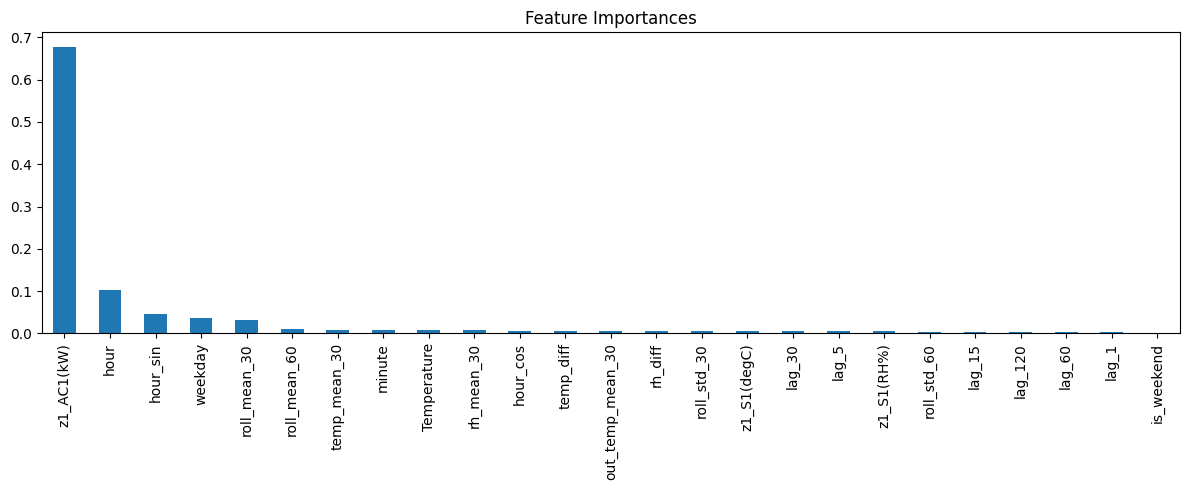

In [10]:

# STEP 11: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# STEP 12: Train XGBoost model
model = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Save model
joblib.dump(model, 'xgb_ac_consumption_model.pkl')

# STEP 13: Predict and evaluate
y_pred = model.predict(X_test)

print("✅ Model Performance:")
print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# STEP 14: Plot feature importance
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', figsize=(12, 5), title='Feature Importances')
plt.tight_layout()
plt.show()

version 2


✅ Original dataset size: (485280, 5)
✅ Dataset after feature engineering: (485100, 27)
✅ Final features: 25
✅ Training size: (388080, 25) Testing size: (97020, 25)

✅ Model Performance:
R² Score: 0.8036047879870053
MAE: 2.860493233544135
RMSE: 5.393746351814406


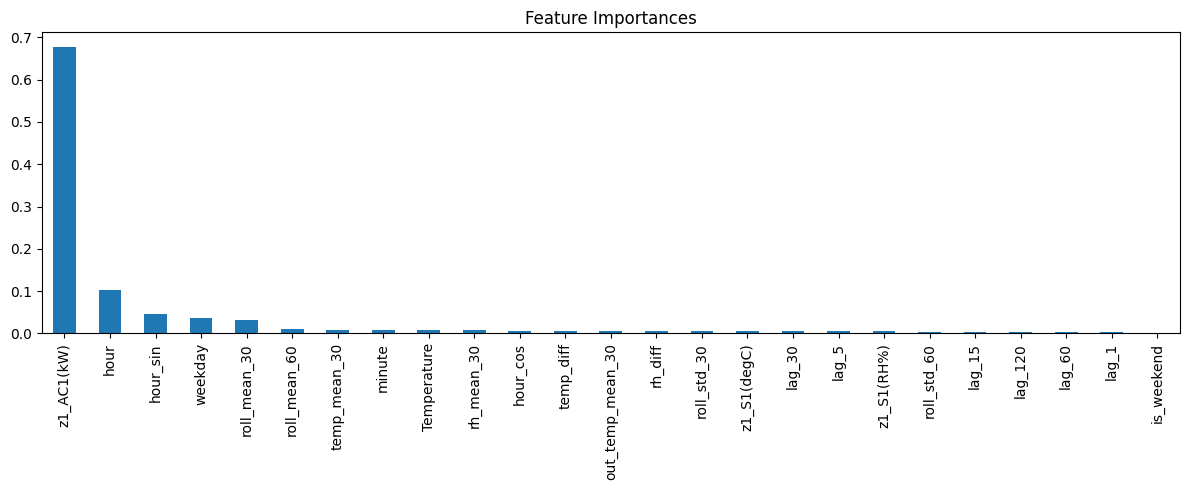


⏱️ Total execution time: 2.17 seconds


In [11]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import joblib
import matplotlib.pyplot as plt

# Start timer
start_time = time.time()

# STEP 1: Load dataset
df = pd.read_csv(r'floor2_with_weather (2).csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
df = df.sort_index()

print("✅ Original dataset size:", df.shape)

# STEP 2: Basic Time Features
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df['weekday'] = df.index.dayofweek
df['is_weekend'] = (df['weekday'] >= 5).astype(int)

# STEP 3: Cyclical Time Encoding
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# STEP 4: Lag Features
df['lag_1'] = df['z1_AC1(kW)'].shift(1)
df['lag_5'] = df['z1_AC1(kW)'].shift(5)
df['lag_15'] = df['z1_AC1(kW)'].shift(15)
df['lag_30'] = df['z1_AC1(kW)'].shift(30)
df['lag_60'] = df['z1_AC1(kW)'].shift(60)
df['lag_120'] = df['z1_AC1(kW)'].shift(120)

# STEP 5: Rolling Statistics
df['roll_mean_30'] = df['z1_AC1(kW)'].rolling(window=30).mean()
df['roll_std_30']  = df['z1_AC1(kW)'].rolling(window=30).std()
df['roll_mean_60'] = df['z1_AC1(kW)'].rolling(window=60).mean()
df['roll_std_60']  = df['z1_AC1(kW)'].rolling(window=60).std()

# STEP 6: Environmental Rolling Stats
df['temp_mean_30'] = df['z1_S1(degC)'].rolling(30).mean()
df['rh_mean_30'] = df['z1_S1(RH%)'].rolling(30).mean()
df['out_temp_mean_30'] = df['Temperature'].rolling(30).mean()

# STEP 7: Difference Features
df['temp_diff'] = df['z1_S1(degC)'] - df['Temperature']
if 'Humidity' in df.columns:
    df['rh_diff'] = df['z1_S1(RH%)'] - df['Humidity']
else:
    df['rh_diff'] = np.nan  # fallback if external humidity not present

# STEP 8: Target Variable
df['target'] = df['z1_AC1(kW)'].shift(-60)

# STEP 9: Drop NA
df = df.dropna()
print("✅ Dataset after feature engineering:", df.shape)

# STEP 10: Define Features
features = [
    'z1_AC1(kW)', 'z1_S1(degC)', 'z1_S1(RH%)', 'Temperature',
    'hour', 'minute', 'weekday', 'is_weekend',
    'hour_sin', 'hour_cos',
    'lag_1', 'lag_5', 'lag_15', 'lag_30', 'lag_60', 'lag_120',
    'roll_mean_30', 'roll_std_30', 'roll_mean_60', 'roll_std_60',
    'temp_mean_30', 'rh_mean_30', 'out_temp_mean_30',
    'temp_diff', 'rh_diff'
]

X = df[features]
y = df['target']

print("✅ Final features:", len(features))

# STEP 11: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
print("✅ Training size:", X_train.shape, "Testing size:", X_test.shape)

# STEP 12: Train XGBoost Model
model = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Save model
joblib.dump(model, 'xgb_ac_consumption_model.pkl')

# STEP 13: Predict & Evaluate
y_pred = model.predict(X_test)

print("\n✅ Model Performance:")
print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# STEP 14: Feature Importance Plot
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', figsize=(12, 5), title='Feature Importances')
plt.tight_layout()
plt.show()

# Time summary
print("\n⏱️ Total execution time: {:.2f} seconds".format(time.time() - start_time))


In [ ]:
version 3

Original dataset size: (485280, 5)
Dataset after FE: (485100, 27)
Number of features: 27
Train/Test shape: (388080, 27) (97020, 27)
After variance threshold: 27 features retained

Model performance:
R²: 0.7914688996692445
MAE: 3.002727145143712
RMSE: 5.5578969328896966


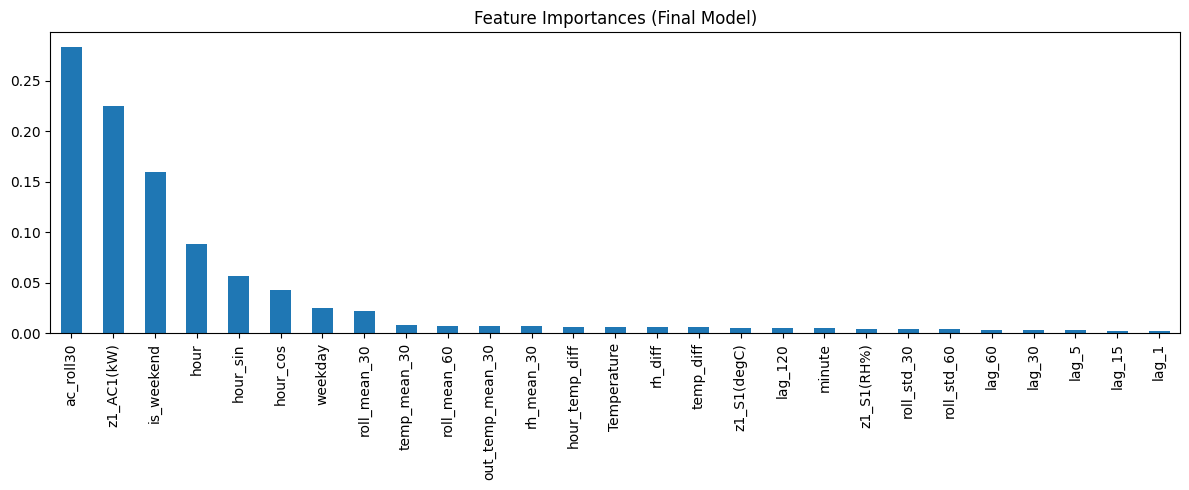

Total run time: 5.97s


In [12]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBRegressor
import joblib
import matplotlib.pyplot as plt

start_time = time.time()

# STEP 1: Load & sort data
df = pd.read_csv('floor2_with_weather (2).csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
df.sort_index(inplace=True)

print("Original dataset size:", df.shape)

# STEP 2–7: Feature Engineering
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df['weekday'] = df.index.dayofweek
df['is_weekend'] = (df['weekday'] >= 5).astype(int)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

lags = [1,5,15,30,60,120]
for lag in lags:
    df[f'lag_{lag}'] = df['z1_AC1(kW)'].shift(lag)

for w in [30, 60]:
    df[f'roll_mean_{w}'] = df['z1_AC1(kW)'].rolling(window=w).mean()
    df[f'roll_std_{w}'] = df['z1_AC1(kW)'].rolling(window=w).std()

df['temp_mean_30'] = df['z1_S1(degC)'].rolling(30).mean()
df['rh_mean_30'] = df['z1_S1(RH%)'].rolling(30).mean()
df['out_temp_mean_30'] = df['Temperature'].rolling(30).mean()
df['temp_diff'] = df['z1_S1(degC)'] - df['Temperature']
df['rh_diff'] = df['z1_S1(RH%)'] - df.get('Humidity', np.nan)

df['target'] = df['z1_AC1(kW)'].shift(-60)

df.dropna(inplace=True)
print("Dataset after FE:", df.shape)

# STEP 8: Feature list including interactions
numerical = ['z1_AC1(kW)', 'z1_S1(degC)', 'z1_S1(RH%)', 'Temperature',
             'hour', 'minute', 'weekday', 'hour_sin', 'hour_cos'] + \
            [f'lag_{l}' for l in lags] + \
            [f'roll_mean_{w}' for w in [30,60]] + \
            [f'roll_std_{w}' for w in [30,60]] + \
            ['temp_mean_30', 'rh_mean_30', 'out_temp_mean_30',
             'temp_diff', 'rh_diff', 'is_weekend']

df['hour_temp_diff'] = df['hour'] * df['temp_diff']
df['ac_roll30'] = df['z1_AC1(kW)'] * df['roll_mean_30']

features = numerical + ['hour_temp_diff', 'ac_roll30']

X = df[features]
y = df['target']

print("Number of features:", len(features))

# STEP 9: Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, test_size=0.2
)
print("Train/Test shape:", X_train.shape, X_test.shape)

# STEP 10: Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# STEP 11: Remove low-variance features
selector = VarianceThreshold(threshold=0.001)
X_train_sel = selector.fit_transform(X_train_scaled)
X_test_sel = selector.transform(X_test_scaled)
print("After variance threshold:", X_train_sel.shape[1], "features retained")

# STEP 12: Train XGBoost with tuned params
model = XGBRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist'
)
model.fit(X_train_sel, y_train)

# Save artifacts
joblib.dump({'model': model, 'scaler': scaler, 'selector': selector}, 'pipeline_ac_model.pkl')

# STEP 13: Prediction & evaluation
y_pred = model.predict(X_test_sel)
print("\nModel performance:")
print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# STEP 14: Feature importances
imap = selector.get_support(indices=True)
imp_features = [features[i] for i in imap]
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=imp_features).sort_values(ascending=False)
feat_imp.plot(kind='bar', figsize=(12, 5), title='Feature Importances (Final Model)')
plt.tight_layout()
plt.show()

print("Total run time: {:.2f}s".format(time.time() - start_time))


 version 4


📊 Model Performance:
R² Score: 0.7865103255915358
MAE: 3.081456812894588
RMSE: 5.623588172760857

🔍 Calculating permutation importances (takes time)...


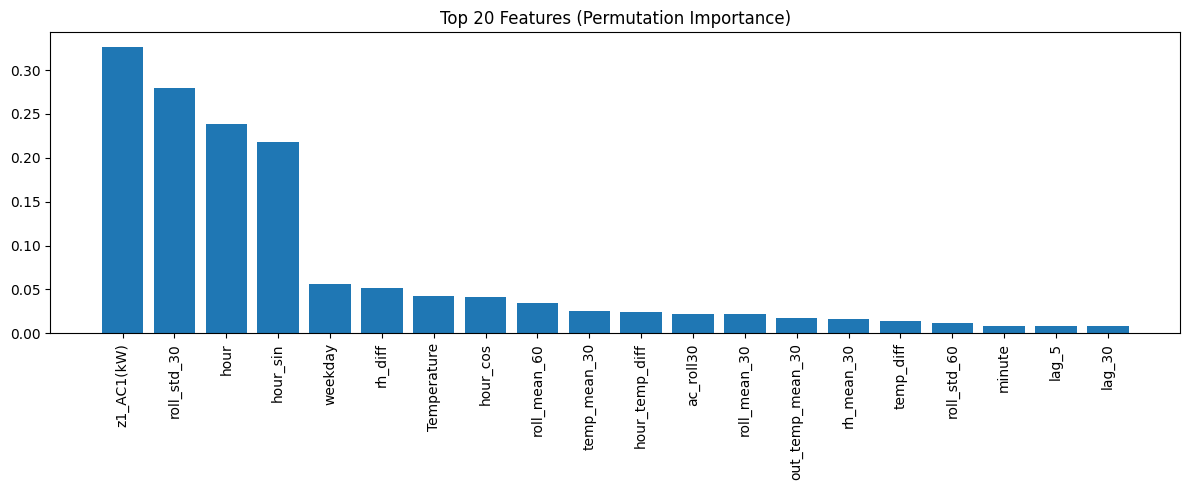


✅ Top 10 most important features:
1. z1_AC1(kW)
2. roll_std_30
3. hour
4. hour_sin
5. weekday
6. rh_diff
7. Temperature
8. hour_cos
9. roll_mean_60
10. temp_mean_30

⏱️ Total execution time: 33.62 seconds


In [13]:
import pandas as pd
import numpy as np
import time
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance

start_time = time.time()

# Load data
df = pd.read_csv('floor2_with_weather (2).csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
df.sort_index(inplace=True)

# Time features
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df['weekday'] = df.index.dayofweek
df['is_weekend'] = (df['weekday'] >= 5).astype(int)

# Cyclical time encodings
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)

# Lag and rolling features
lags = [1, 5, 15, 30, 60, 120]
for lag in lags:
    df[f'lag_{lag}'] = df['z1_AC1(kW)'].shift(lag)

for w in [30, 60]:
    df[f'roll_mean_{w}'] = df['z1_AC1(kW)'].rolling(window=w).mean()
    df[f'roll_std_{w}'] = df['z1_AC1(kW)'].rolling(window=w).std()

# Environmental rolling features
df['temp_mean_30'] = df['z1_S1(degC)'].rolling(30).mean()
df['rh_mean_30'] = df['z1_S1(RH%)'].rolling(30).mean()
df['out_temp_mean_30'] = df['Temperature'].rolling(30).mean()

# Diff features
df['temp_diff'] = df['z1_S1(degC)'] - df['Temperature']
df['rh_diff'] = df['z1_S1(RH%)'] - df.get('Humidity', np.nan)

# Interaction features
df['hour_temp_diff'] = df['hour'] * df['temp_diff']
df['ac_roll30'] = df['z1_AC1(kW)'] * df['roll_mean_30']

# Target: 1 hour ahead prediction
df['target'] = df['z1_AC1(kW)'].shift(-60)

# Clean up
df.dropna(inplace=True)

# Feature list
features = [
    'z1_AC1(kW)', 'z1_S1(degC)', 'z1_S1(RH%)', 'Temperature',
    'hour', 'minute', 'weekday', 'is_weekend',
    'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos',
    *[f'lag_{l}' for l in lags],
    *[f'roll_mean_{w}' for w in [30, 60]],
    *[f'roll_std_{w}' for w in [30, 60]],
    'temp_mean_30', 'rh_mean_30', 'out_temp_mean_30',
    'temp_diff', 'rh_diff',
    'hour_temp_diff', 'ac_roll30'
]

X = df[features]
y = df['target']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Remove low variance features
selector = VarianceThreshold(threshold=0.001)
X_train_sel = selector.fit_transform(X_train_scaled)
X_test_sel = selector.transform(X_test_scaled)
selected_features = [features[i] for i in selector.get_support(indices=True)]

# Model
model = XGBRegressor(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist'
)
model.fit(X_train_sel, y_train)

# Save pipeline
joblib.dump({'model': model, 'scaler': scaler, 'selector': selector}, 'pipeline_ac_model_enhanced.pkl')

# Prediction & evaluation
y_pred = model.predict(X_test_sel)

print("\n📊 Model Performance:")
print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Permutation Importance (Best way to rank features)
print("\n🔍 Calculating permutation importances (takes time)...")
result = permutation_importance(model, X_test_sel, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_sorted_idx = result.importances_mean.argsort()[::-1]

# Plot top features
top_features = [selected_features[i] for i in perm_sorted_idx]
top_importances = result.importances_mean[perm_sorted_idx]

plt.figure(figsize=(12, 5))
plt.bar(top_features[:20], top_importances[:20])
plt.xticks(rotation=90)
plt.title("Top 20 Features (Permutation Importance)")
plt.tight_layout()
plt.show()

# Summary of best features
print("\n✅ Top 10 most important features:")
for i in range(10):
    print(f"{i+1}. {top_features[i]}")

print("\n⏱️ Total execution time: {:.2f} seconds".format(time.time() - start_time))
